### Gas Noise Test

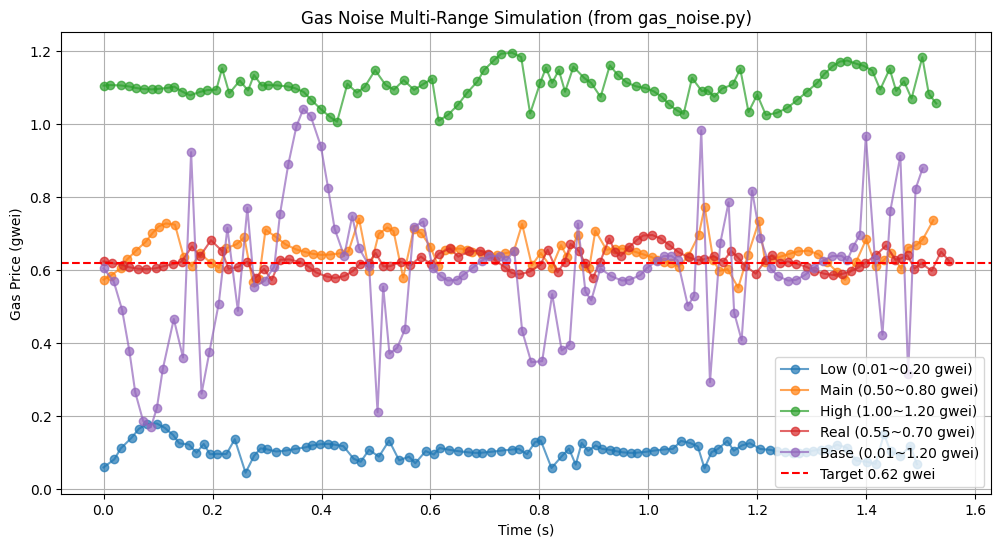

In [6]:
import matplotlib.pyplot as plt
from gas_noise import generate_gas_sequence

def run_and_plot(min_gwei, max_gwei, steps=100, switch_period=10, seed=None, label=None, color=None):
    min_wei = int(min_gwei * 1e9)
    max_wei = int(max_gwei * 1e9)
    prices, times = generate_gas_sequence(
        min_gas=min_wei,
        max_gas=max_wei,
        steps=steps,
        switch_period=switch_period,
        interval_min=0.01,
        interval_max=0.02,
        seed=seed,
        write_toml=False,
        verbose=False
    )
    prices_gwei = [p / 1e9 for p in prices]
    plt.plot(times, prices_gwei, marker='o', alpha=0.7, label=label, color=color)

plt.figure(figsize=(12,6))
run_and_plot(0.01, 0.20, steps=100, switch_period=10, seed=1, label='Low (0.01~0.20 gwei)')
run_and_plot(0.50, 0.80, steps=100, switch_period=10, seed=2, label='Main (0.50~0.80 gwei)')
run_and_plot(1.00, 1.20, steps=100, switch_period=10, seed=3, label='High (1.00~1.20 gwei)')
run_and_plot(0.55, 0.70, steps=100, switch_period=10, seed=4, label='Real (0.55~0.70 gwei)')
run_and_plot(0.01, 1.20, steps=100, switch_period=10, seed=5, label='Base (0.01~1.20 gwei)')
plt.axhline(0.62, color='r', linestyle='--', label='Target 0.62 gwei')
plt.xlabel('Time (s)')
plt.ylabel('Gas Price (gwei)')
plt.title('Gas Noise Multi-Range Simulation (from gas_noise.py)')
plt.legend()
plt.grid(True)
plt.show()
